# GBIF_Request

In [26]:
!pip install pygbif --quiet
!pip install geopandas --quiet


## Fazendo uma aquisição completa para uma espécie

In [27]:
import requests
payload = {'taxonKey': '3873513','publishingCountry':'BR','limit':300,'hasCoordinate':True,'year':'2000,2020'} # sem hasCoordinate vem 900 e com vem 400
r = requests.get("http://api.gbif.org/v1/occurrence/search", params=payload)
#r = requests.get('http://api.gbif.org/v1/occurrence/search?taxonKey=3873513')
print("Response status: ",r)

Response status:  <Response [200]>


In [28]:
reponse = r.json()
reponse

{'count': 315,
 'endOfRecords': False,
 'facets': [],
 'limit': 300,
 'offset': 0,
 'results': [{'acceptedScientificName': 'Cynophalla hastata J.Presl',
   'acceptedTaxonKey': 3873513,
   'basisOfRecord': 'PRESERVED_SPECIMEN',
   'catalogNumber': '22903',
   'class': 'Magnoliopsida',
   'classKey': 220,
   'collectionCode': 'HST',
   'country': 'Brazil',
   'countryCode': 'BR',
   'crawlId': 222,
   'datasetKey': 'b3769e61-c3d0-4046-81cf-bf4d6b23b444',
   'datasetName': 'HST - Herbário Sérgio Tavares',
   'day': 9,
   'decimalLatitude': -6.08,
   'decimalLongitude': -35.8575,
   'elevation': 218.0,
   'elevationAccuracy': 0.0,
   'eventDate': '2019-03-09T00:00:00',
   'extensions': {},
   'facts': [],
   'family': 'Capparaceae',
   'familyKey': 3111,
   'gbifID': '2452748819',
   'genericName': 'Cynophalla',
   'genus': 'Cynophalla',
   'genusKey': 6370797,
   'geodeticDatum': 'WGS84',
   'identifiedByIDs': [],
   'identifier': 'BRA:UFRPE:HST:22903',
   'identifiers': [],
   'installat

In [29]:
reponse['results'][1]

{'acceptedScientificName': 'Cynophalla hastata J.Presl',
 'acceptedTaxonKey': 3873513,
 'basisOfRecord': 'PRESERVED_SPECIMEN',
 'catalogNumber': '132322',
 'class': 'Magnoliopsida',
 'classKey': 220,
 'collectionCode': 'ALCB',
 'continent': 'SOUTH_AMERICA',
 'country': 'Brazil',
 'countryCode': 'BR',
 'crawlId': 210,
 'datasetKey': '5b5cf455-a448-4c0a-aecd-3e0956f27f10',
 'datasetName': 'ALCB - Herbário Alexandre Leal Costa',
 'dateIdentified': '2018-06-01T00:00:00',
 'day': 20,
 'decimalLatitude': -9.45,
 'decimalLongitude': -41.883333,
 'eventDate': '2018-01-20T00:00:00',
 'extensions': {},
 'facts': [],
 'family': 'Capparaceae',
 'familyKey': 3111,
 'gbifID': '1889188943',
 'genericName': 'Cynophalla',
 'genus': 'Cynophalla',
 'genusKey': 6370797,
 'geodeticDatum': 'WGS84',
 'identifiedBy': 'Guedes, ML',
 'identifiedByIDs': [],
 'identifier': 'BRA:UFBA:ALCB:132322',
 'identifiers': [],
 'installationKey': 'b38ff2b7-c8af-454e-b5af-ee760f0d5bca',
 'institutionCode': 'Universidade Fede

## Global Variables

Para dar menos trabalho pra 

In [30]:
# import os
# shapefiles_folder = '/content/drive/My Drive/TFC_MatheusSasso/Coolabs/Data/Shapefiles_Brasil'
# shapefile_brasi_pais_folder = shapefiles_folder + '/Pais'
# shapefile_brasi_estado_folder = shapefiles_folder + '/Estados'
# shapefile_brasi_municipio_folder = shapefiles_folder + '/Municipios'
# shapefile_brasi_distrito_folder = shapefiles_folder + '/Distritos'
# brasil_pais_shp = os.path.join(shapefile_brasi_pais_folder, 'BRA_adm0.shp')
# brasil_estados_shp = os.path.join(shapefile_brasi_estado_folder, 'BRA_adm1.shp')
# brasil_municipos_shp = os.path.join(shapefile_brasi_municipio_folder, 'BRA_adm2.shp')
# brasil_distritos_shp = os.path.join(shapefile_brasi_distrito_folder, 'BRA_adm3.shp')
# import geopandas as gpd
# # Read file using gpd.read_file()
# brasil_pais = gpd.read_file(brasil_pais_shp)
# brasil_estados = gpd.read_file(brasil_estados_shp)
# brasil_municipos = gpd.read_file(brasil_municipos_shp)
# brasil_distritos = gpd.read_file(brasil_distritos_shp)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Classe CountryShapefile

In [32]:
import os
from osgeo import ogr
import geopandas as gpd

# Fazer Composição com continente no futuro
class Country:
  def __init__(self, shapefiles_folder:str ='/content/drive/My Drive/TFC_MatheusSasso/Coolabs/Data/Shapefiles_Brasil'):
    
    #Folder
    shapefile_brasi_pais_folder = shapefiles_folder + '/Pais'
    shapefile_brasi_estado_folder = shapefiles_folder + '/Estados'
    shapefile_brasi_municipio_folder = shapefiles_folder + '/Municipios'
    shapefile_brasi_distrito_folder = shapefiles_folder + '/Distritos'
    
    #Complete file path
    self._brasil_pais_path = os.path.join(shapefile_brasi_pais_folder, 'BRA_adm0.shp')
    self._brasil_estados_path = os.path.join(shapefile_brasi_estado_folder, 'BRA_adm1.shp')
    self._brasil_municipos_path = os.path.join(shapefile_brasi_municipio_folder, 'BRA_adm2.shp')
    self._brasil_distritos_path = os.path.join(shapefile_brasi_distrito_folder, 'BRA_adm3.shp')

    # GeoDataFrame
    self._brasil_pais = gpd.read_file(self._brasil_pais_path)
    self._brasil_estados = gpd.read_file(self._brasil_estados_path)
    self._brasil_municipos = gpd.read_file(self._brasil_municipos_path)
    self._brasil_distritos = gpd.read_file(self._brasil_distritos_path)
  
  def get_brasil_pais_gdf(self):
    return self._brasil_pais

  def get_brasil_estados_gdf(self):
    return self._brasil_estados

  def get_brasil_municipos_gdf(self):
    return self._brasil_municipos

  def get_brasil_distritos_gdf(self):
    return self._brasil_distritos

  def get_df_only_with_inside_country_points(self,df,name_index:str='NAME_ISO',country_index:str='COUNTRY',lat_index:str='LATITUDE',lon_index:str='LONGITUDE'):
    # open shapefile containing country polygons
    #filename = '/content/drive/My Drive/TFC_MatheusSasso/Coolabs/Data/Shapefiles_World/TM_WORLD_BORDERS-0.3.shp'
    filename = self._brasil_pais_path
    drv = ogr.GetDriverByName('ESRI Shapefile')                     # set up driver object to read/write shapefiles
    shapefile = drv.Open(filename) # open shapefile
    layer = shapefile.GetLayer(0)                                   # create layer object for shapefile
    # determine indices of relevant columns
    nameIndex = layer.GetLayerDefn().GetFieldIndex(name_index)       # index of column with country names in shapefile 
    countryIndex = df.columns.get_loc(country_index)       # index of country name column in observation table                                                            
    latIndex = df.columns.get_loc(lat_index)               # index of lat column in observation table
    lonIndex = df.columns.get_loc(lon_index)               # index of lon column in observation table

    # set up list in which we will store the results of looking up the containing country for each row
    geocodingResults = []  

    # itertuples is used to efficiently loop through the rows of the data frame
    for row in df.itertuples(index=False):  

        # create a new OGR point object with lon and lat coordinates from current row 
        pt = ogr.Geometry(ogr.wkbPoint)                    
        pt.SetPoint_2D(0, row[lonIndex], row[latIndex] )  

        # apply spatial filter that will give us polygons that intersect our point
        layer.SetSpatialFilter(pt)                         

        country = "UNKNOWN"           # variable for storing the country's name

        # check whether there's exactly one feature selected, if get country name of that feature
        if layer.GetFeatureCount() == 1:                   
            country = layer.GetNextFeature().GetFieldAsString(nameIndex).title()
        
        # add country name to result list
        geocodingResults.append(country)                   
    
    df['country_geocoding'] = geocodingResults  # add geocoding results as new column

    df = df [(df.country_geocoding == df.COUNTRY)|(df.country_geocoding == 'Brazil')]
    return df

Classe Specie_Info

## Classe Genérica para fazer a requisição

In [38]:
import requests
import pandas as pd
import os
import geopandas as gpd

#Alguns outros parâmtreos interessantes que podem ser considerados 
#elevation: Elevation (altitude) in meters above sea level. Supports range queries.
#establishmentMeans: EstablishmentMeans, as defined in our EstablishmentMeans enum
#repatriated: Searches for records whose publishing country is different to the country where the record was recorded in.

class Specie:
  def __init__(self,
               taxonKey:int,
               countryObj:object=None,
               limit:int =300,
               hasCoordinate: bool=True,
               lowYear=None,
               upYear=None,
               dropDuplicates:bool=True,
               tryOverrideSpecieData:bool=False):
    

    #-------Country Object
    self._countryObj = countryObj

    #--------Parameters
    self._taxonKey = taxonKey
    self._limit = limit
    self._hasCoordinate = hasCoordinate
    self._lowYear = lowYear
    self._upYear = upYear
    assert (lowYear and upYear),"You must provide lowYear and upYear" 
    self._year_range = str(lowYear) + ',' +str(upYear)
    self._dropDuplicates = dropDuplicates
    self._tryOverrideSpecieData = tryOverrideSpecieData

    #--------Data Retrieval
    if (not self._tryOverrideSpecieData) and (self._data_reader()):
      print("In this case GBIF request was not necessary, we got gdf from Shapefile")
      self._r = None
      self._df = None
      self._gdf = self._data_reader()
    else:
      print("In this case GBIF request was necessary to create gdf file")
      self._r = self._gbif_request_json_request()
      df_dirty = self._create_specie_dataframe()
      self._df = self._get_inside_country_dataframe(df_dirty)
      self._gdf = self._create_specie_geo_dataframe()
      print('Effectively ' + str(len(self._gdf)) + ' examplars are inside country boarders')
      self._shp_exporter()
      

  #-------- Private Methods 
  
  def _gbif_request_json_request(self):
    payload = {'taxonKey': str(self._taxonKey) ,'limit':self._limit,'hasCoordinate':self._hasCoordinate,'year':self._year_range,'country':'BR'} 
    r = requests.get("http://api.gbif.org/v1/occurrence/search", params=payload)
    r = r.json()
    print(str(r['count']) + ' occurrences were found. The limit of occurrences per request is ' + str(self._limit))
    return r


  def _data_reader(self):
    species_folder = '/content/drive/My Drive/TFC_MatheusSasso/Coolabs/Data/Species'
    specie_id_file = str(self.taxonKey) + '.shp'
    fp = os.path.join(species_folder, specie_id_file)
    try:
     gdf = gpd.read_file(fp) 
    except FileNotFoundError:
     gdf = None
    return gdf      
  
  def _shp_exporter(self):
    species_folder = '/content/drive/My Drive/TFC_MatheusSasso/Coolabs/Data/Species'
    specie_id_file = str(self._taxonKey) + '.shp'
    output_fp = os.path.join(species_folder, specie_id_file)
    self._gdf.to_file(output_fp)
  
  def _refact_dict(self, result):
    columns = result.keys()
    desired_columns = ['scientificName','decimalLongitude','decimalLatitude','country','stateProvince','eventDate','day','month','year','occurrenceRemarks']
    for d_col in desired_columns:
      if d_col not in columns:
        result[d_col] = None
    return result

  def _create_specie_dataframe(self):
    df = pd.DataFrame(columns=['SCIENTIFIC_NAME','LONGITUDE','LATITUDE','COUNTRY','STATE_PROVINCE','IDENTIFICATION_DATE','DAY','MONTH','YEAR','OCCURENCE_REMARKS'])
    for result in self._r['results']:
      result = self._refact_dict(result)
      df = df.append({
          "SCIENTIFIC_NAME": result['scientificName'],
          "LONGITUDE": result['decimalLongitude'],
          "LATITUDE":  result['decimalLatitude'],
          "COUNTRY":  result['country'],
          "STATE_PROVINCE":  result['stateProvince'],
          "IDENTIFICATION_DATE":  result['eventDate'],
          "DAY":  result['day'],
          "MONTH":  result['month'],
          "YEAR":  result['year'],
          "OCCURENCE_REMARKS":  result['occurrenceRemarks']
          }, ignore_index=True)
      df = df.drop_duplicates(ignore_index=True) if self._dropDuplicates else df
      df.sort_values("STATE_PROVINCE", inplace = True,ignore_index=True)
    return df

  def _get_inside_country_dataframe(self,df):
    if self._countryObj:
      insde_country_df = self._countryObj.get_df_only_with_inside_country_points(df,
                                                                                 name_index='NAME_ISO',
                                                                                 country_index='COUNTRY',
                                                                                 lat_index='LATITUDE',
                                                                                 lon_index='LONGITUDE')
    else:
      insde_country_df = df
    return insde_country_df

  def _create_specie_geo_dataframe(self):
    gdf = gpd.GeoDataFrame(self._df, geometry=gpd.points_from_xy(self._df.LONGITUDE, self._df.LATITUDE))
    
    return gdf
    
  #-------- Public Methods
  def get_specie_df(self):
    return self._df
  
  def get_specie_gdf(self):
    return self._gdf


## Trabalhando Instâncias 

In [34]:
brasil = Country()

criando instancia

In [39]:
specie1 = Specie(taxonKey=3873513,countryObj=brasil,limit=300,hasCoordinate=True,lowYear=2000,upYear=2020,dropDuplicates=True,tryOverrideSpecieData=True)

In this case GBIF request was necessary to create gdf file
317 occurrences were found. The limit of occurrences per request is 300
Effectively 286 examplars are inside country boarders


recuperandos dados

In [40]:
gdf = specie1.get_specie_gdf()
gdf.head()

,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,OCCURENCE_REMARKS,country_geocoding,geometry
0,Cynophalla hastata J.Presl,-36.583333,-10.283333,Brazil,Alagoas,2017-04-29T00:00:00,29,4,2017,escandente. Folhas coriáceas. Inflorescência a...,Brazil,POINT (-36.58333 -10.28333)
1,Cynophalla hastata J.Presl,-37.774036,-9.743700,Brazil,Alagoas,2009-02-21T00:00:00,21,2,2009,Arvoreta ca. de 3m de altura. Frutos verdes.; ...,Brazil,POINT (-37.77404 -9.74370)
2,Cynophalla hastata J.Presl,-36.305839,-9.577389,Brazil,Alagoas,2009-10-17T00:00:00,17,10,2009,"Arbusto ca. 3,5 m de altura. Flores brancas.; ...",Brazil,POINT (-36.30584 -9.57739)
3,Cynophalla hastata J.Presl,-36.911106,-9.444397,Brazil,Alagoas,2010-01-30T00:00:00,30,1,2010,Arbusto escandente ca. 4 m de altura. Flores c...,Brazil,POINT (-36.91111 -9.44440)
4,Cynophalla hastata J.Presl,-37.732506,-10.271111,Brazil,Alagoas,2010-01-15T00:00:00,15,1,2010,Arbusto ca. 2 m de altura. Botões verdes.; Caa...,Brazil,POINT (-37.73251 -10.27111)


## Printing data

In [41]:
import matplotlib.pyplot as plt
def plot_location_map(gdf,specie_color='red'):
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

  # We restrict to South America.
  ax = world[world.name == 'Brazil'].plot(
      color='white', edgecolor='black')

  # We can now plot our ``GeoDataFrame``.
  gdf['geometry'].plot(ax=ax, color=specie_color)

  plt.show()

In [42]:
gdf['geometry']

0      POINT (-36.58333 -10.28333)
1       POINT (-37.77404 -9.74370)
2       POINT (-36.30584 -9.57739)
3       POINT (-36.91111 -9.44440)
4      POINT (-37.73251 -10.27111)
                  ...             
291    POINT (-37.40976 -10.03611)
292    POINT (-37.64528 -10.87964)
293     POINT (-37.68417 -9.80528)
294    POINT (-36.96722 -10.11367)
295    POINT (-37.35553 -10.09750)
Name: geometry, Length: 286, dtype: geometry

In [43]:
type(gdf['geometry'])


geopandas.geoseries.GeoSeries

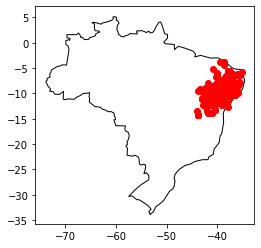

In [44]:
plot_location_map(gdf)

## Looking for Duplicates Tests

In [ ]:
df = gbif_requester.get_specie_dataframe(3873513)

317 occurrences were found. The limit of occurrences per request is 300


In [ ]:
df

,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,OCCURENCE_REMARKS
0,Cynophalla hastata J.Presl,-35.857500,-6.080000,Brazil,Rio Grande do Norte,2019-03-09T00:00:00,9,3,2019,Arbusto; folhas verde-escuras; frutos imaturos...
1,Cynophalla hastata J.Presl,-41.883333,-9.450000,Brazil,Bahia,2018-01-20T00:00:00,20,1,2018,"escandente. Folhas cartáceas, discolores. Infl..."
2,Cynophalla hastata J.Presl,-43.019722,-10.979722,Brazil,Bahia,2018-01-23T00:00:00,23,1,2018,"Liana/cipó; 4 metros . Fruto imaturo; 1,5X8,0 ..."
3,Cynophalla hastata J.Presl,-35.660556,-6.210000,Brazil,Rio Grande do Norte,2018-02-02T00:00:00,2,2,2018,"Ca de 1,5 m de alt. Folhas verde-claras. Botõe..."
4,Cynophalla hastata J.Presl,-39.266667,-11.550000,Brazil,Bahia,2018-04-22T00:00:00,22,4,2018,"Folhas coriáceas, discolores. Inflorescência c..."
...,...,...,...,...,...,...,...,...,...,...
295,Cynophalla hastata J.Presl,-43.752778,-14.238889,Brazil,Bahia,2001-04-21T00:00:00,21,4,2001,Caatinga.
296,Cynophalla hastata J.Presl,-40.419722,-13.258889,Brazil,Bahia,2001-05-15T00:00:00,15,5,2001,"ca. 3m. Folha coriácea, levemente discolor. Pé..."
297,Capparis coccolobifolia Mart.,-40.419722,-13.258889,Brazil,Bahia,2001-05-15T00:00:00,15,5,2001,; HABITAT: Vegetação antropizada entre rochas....
298,Cynophalla hastata J.Presl,-40.419722,-13.258889,Brazil,Bahia,2001-05-15T00:00:00,15,5,2001,None


In [ ]:
df.sort_values("LONGITUDE", inplace = True,ignore_index=True)

In [ ]:
df

,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,OCCURENCE_REMARKS
0,Cynophalla hastata J.Presl,-44.077500,-13.383333,Brazil,Bahia,2006-10-20T00:00:00,20,10,2006,Floresta estacional decidual.
1,Cynophalla hastata J.Presl,-43.872778,-9.483889,Brazil,Bahia,2003-07-02T00:00:00,2,7,2003,"Caatinga arbórea com solo argiloso, latosolo v..."
2,Cynophalla hastata J.Presl,-43.784444,-14.336389,Brazil,Bahia,2007-05-26T00:00:00,26,5,2007,"de ca 6 m de altura. Folhas coriáceas, discolo..."
3,Cynophalla hastata J.Presl,-43.784444,-14.336389,Brazil,Bahia,2007-05-26T00:00:00,26,5,2007,Caatinga.
4,Cynophalla hastata J.Presl,-43.777778,-14.327500,Brazil,Bahia,2007-11-24T00:00:00,24,11,2007,Caatinga.
...,...,...,...,...,...,...,...,...,...,...
295,Cynophalla hastata J.Presl,-3.938055,-8.194444,Brazil,Pernambuco,2014-09-18T00:00:00,18,9,2014,"Arbusto apoiante, ca. 5,0 m alt. Folhas coriác..."
296,Cynophalla hastata J.Presl,-3.741389,-8.905833,Brazil,Alagoas,2016-11-08T00:00:00,8,11,2016,None
297,Cynophalla hastata J.Presl,-3.519722,-6.796944,Brazil,Paraíba,2014-11-25T00:00:00,25,11,2014,"Arbusto, ca. 3m. Flores brancas"
298,Cynophalla hastata J.Presl,-3.344722,-7.043055,Brazil,Paraíba,2014-09-24T00:00:00,24,9,2014,"Arbustivo, ca. 4,0 m alt. Folhas coriáceas, ve..."


In [ ]:
nanRows = df[ ~ ( df.LONGITUDE.notnull() & df.LATITUDE.notnull() ) ]
print('Number of nan rows:' + str(len(nanRows)))
nanRows.head()

Number of nan rows:0


,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,OCCURENCE_REMARKS


In [ ]:
dfWithCoordinates = df[ df.LONGITUDE.notnull() & df.LATITUDE.notnull() ]
print('Rows remaining:' + str(len(df)))
dfWithCoordinates.head()

Rows remaining:300


,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,OCCURENCE_REMARKS
0,Cynophalla hastata J.Presl,-44.077500,-13.383333,Brazil,Bahia,2006-10-20T00:00:00,20,10,2006,Floresta estacional decidual.
1,Cynophalla hastata J.Presl,-43.872778,-9.483889,Brazil,Bahia,2003-07-02T00:00:00,2,7,2003,"Caatinga arbórea com solo argiloso, latosolo v..."
2,Cynophalla hastata J.Presl,-43.784444,-14.336389,Brazil,Bahia,2007-05-26T00:00:00,26,5,2007,"de ca 6 m de altura. Folhas coriáceas, discolo..."
3,Cynophalla hastata J.Presl,-43.784444,-14.336389,Brazil,Bahia,2007-05-26T00:00:00,26,5,2007,Caatinga.
4,Cynophalla hastata J.Presl,-43.777778,-14.327500,Brazil,Bahia,2007-11-24T00:00:00,24,11,2007,Caatinga.


In [ ]:
isDuplicate = df.duplicated(keep = 'first')
print(isDuplicate.head())
isDuplicate.value_counts()

0    False
1    False
2    False
3    False
4    False
dtype: bool


False    296
True       4
dtype: int64

In [ ]:
from shapely import speedups
speedups.enabled

True

## Check if inside country boardes

###Using Geopandas (Too SLOW)

In [ ]:
import time
start_time = time.time()
brasil_mask = gdf.within(brasil_pais.at[0, 'geometry'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 683.132199048996 seconds ---


In [ ]:
brasil_mask = gdf.within(brasil_pais.at[0, 'geometry'])

In [ ]:
brasil_mask

0      True
1      True
2      True
3      True
4      True
       ... 
295    True
296    True
297    True
298    True
299    True
Length: 300, dtype: bool

### Using GDAL (Not Fast but Good)

In [ ]:
from osgeo import ogr

# open shapefile containing country polygons
#filename = '/content/drive/My Drive/TFC_MatheusSasso/Coolabs/Data/Shapefiles_World/TM_WORLD_BORDERS-0.3.shp'
filename = brasil_pais_shp
drv = ogr.GetDriverByName('ESRI Shapefile')                     # set up driver object to read/write shapefiles
shapefile = drv.Open(filename) # open shapefile
layer = shapefile.GetLayer(0)                                   # create layer object for shapefile
# determine indices of relevant columns
nameIndex = layer.GetLayerDefn().GetFieldIndex('NAME_ISO')                # index of column with country names in shapefile 
countryIndex = df.columns.get_loc('COUNTRY')       # index of country name column in observation table                                                            
latIndex = df.columns.get_loc('LATITUDE')               # index of lat column in observation table
lonIndex = df.columns.get_loc('LONGITUDE')               # index of lon column in observation table

# print out the results
print('nameIndex: {0}, countryIndex: {1}, latIndex: {2}, lonIndex: {3}'.format(nameIndex, countryIndex, latIndex, lonIndex))     

nameIndex: 3, countryIndex: 3, latIndex: 2, lonIndex: 1


In [ ]:
from osgeo import ogr
import time
start_time = time.time()


# set up list in which we will store the results of looking up the containing country for each row
geocodingResults = []  

# itertuples is used to efficiently loop through the rows of the data frame
for row in df.itertuples(index=False):  

    # create a new OGR point object with lon and lat coordinates from current row 
    pt = ogr.Geometry(ogr.wkbPoint)                    
    pt.SetPoint_2D(0, row[lonIndex], row[latIndex] )  

    # apply spatial filter that will give us polygons that intersect our point
    layer.SetSpatialFilter(pt)                         

    country = "UNKNOWN"           # variable for storing the country's name

    # check whether there's exactly one feature selected, if get country name of that feature
    if layer.GetFeatureCount() == 1:                   
        country = layer.GetNextFeature().GetFieldAsString(nameIndex).title()
    
    # add country name to result list
    geocodingResults.append(country)                   
    
# show the first five elements of the resulting list of country names
geocodingResults[0:5]

print("--- %s seconds ---" % (time.time() - start_time))

--- 40.13271188735962 seconds ---


In [ ]:
geocodingResults

['Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'UNKNOWN',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'UNKNOWN',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'UNKNOWN',
 'UNKNOWN',
 'Brazil',
 'Brazil',
 'Brazil',
 'UNKNOWN',
 'UNKNOWN',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'UNKNOWN',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'B

In [ ]:
new_df = df.copy()
new_df['country_geocoding'] = geocodingResults  # add geocoding results as new column
new_df_clean = new_df [(new_df.country_geocoding == new_df.COUNTRY)|(new_df.country_geocoding == 'Brazil')]
new_df_clean

,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,OCCURENCE_REMARKS,country_geocoding
0,Cynophalla hastata J.Presl,-35.857500,-6.080000,Brazil,Rio Grande do Norte,2019-03-09T00:00:00,9,3,2019,Arbusto; folhas verde-escuras; frutos imaturos...,Brazil
1,Cynophalla hastata J.Presl,-41.883333,-9.450000,Brazil,Bahia,2018-01-20T00:00:00,20,1,2018,"escandente. Folhas cartáceas, discolores. Infl...",Brazil
2,Cynophalla hastata J.Presl,-43.019722,-10.979722,Brazil,Bahia,2018-01-23T00:00:00,23,1,2018,"Liana/cipó; 4 metros . Fruto imaturo; 1,5X8,0 ...",Brazil
3,Cynophalla hastata J.Presl,-35.660556,-6.210000,Brazil,Rio Grande do Norte,2018-02-02T00:00:00,2,2,2018,"Ca de 1,5 m de alt. Folhas verde-claras. Botõe...",Brazil
4,Cynophalla hastata J.Presl,-39.266667,-11.550000,Brazil,Bahia,2018-04-22T00:00:00,22,4,2018,"Folhas coriáceas, discolores. Inflorescência c...",Brazil
...,...,...,...,...,...,...,...,...,...,...,...
295,Cynophalla hastata J.Presl,-43.752778,-14.238889,Brazil,Bahia,2001-04-21T00:00:00,21,4,2001,Caatinga.,Brazil
296,Cynophalla hastata J.Presl,-40.419722,-13.258889,Brazil,Bahia,2001-05-15T00:00:00,15,5,2001,"ca. 3m. Folha coriácea, levemente discolor. Pé...",Brazil
297,Capparis coccolobifolia Mart.,-40.419722,-13.258889,Brazil,Bahia,2001-05-15T00:00:00,15,5,2001,; HABITAT: Vegetação antropizada entre rochas....,Brazil
298,Cynophalla hastata J.Presl,-40.419722,-13.258889,Brazil,Bahia,2001-05-15T00:00:00,15,5,2001,None,Brazil


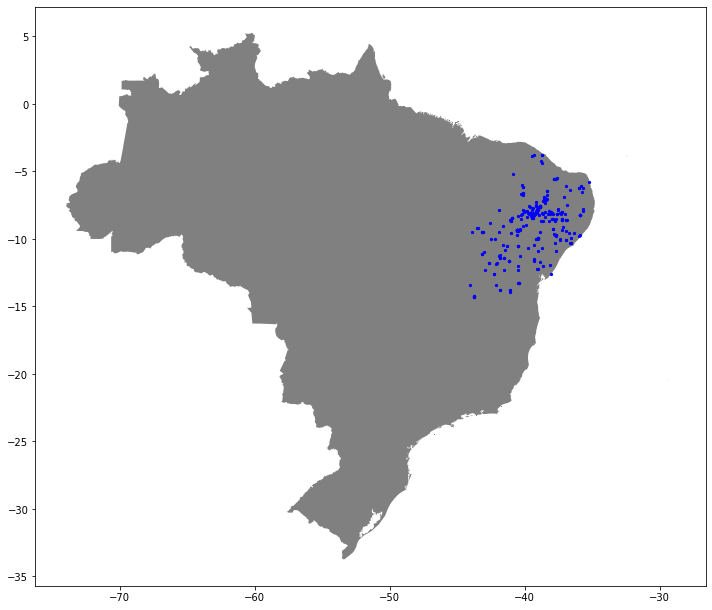

In [ ]:
import matplotlib.pyplot as plt

new_df_clean
new_gdf_clean = geopandas.GeoDataFrame(new_df_clean, geometry=geopandas.points_from_xy(new_df_clean.LONGITUDE, new_df_clean.LATITUDE))

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot polygons
brasil_pais.plot(ax=ax, facecolor='gray')
# Plot points
new_gdf_clean.plot(ax=ax, color='blue', markersize=5)

plt.tight_layout()